# Clean Reddit Text Data

In [2]:
import disinfo as di
from disinfo import topicAnalysis

import pandas as pd
import itertools

# Read test data 
submissions = pd.read_csv("../test_data/example_subs.csv")

topic_a = topicAnalysis(submissions)

In [6]:
def count_words(words):
    counts = dict()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts


In [8]:
words = topic_a.lemmas

merged = list(itertools.chain(*words))

word_count = count_words(merged)

word_count_ordered = sorted(word_count.items(), key=lambda x: x[1], reverse=True)

word_count_dataframe = pd.DataFrame(word_count_ordered)

word_count_dataframe = word_count_dataframe.rename(columns= {0: 'lemma', 1: 'word_count'})

# Word Analysis

How many words lemmas only appear once?

In [10]:
lemmas_more_than_once = len(word_count_dataframe[word_count_dataframe.word_count > 1]) / len(word_count_dataframe)

lemmas_more_than_once = round(lemmas_more_than_once, 2) * 100

print(f"The percentage of words that appears more than once are {lemmas_more_than_once}%")

The percentage of words that appears more than once are 46.0%


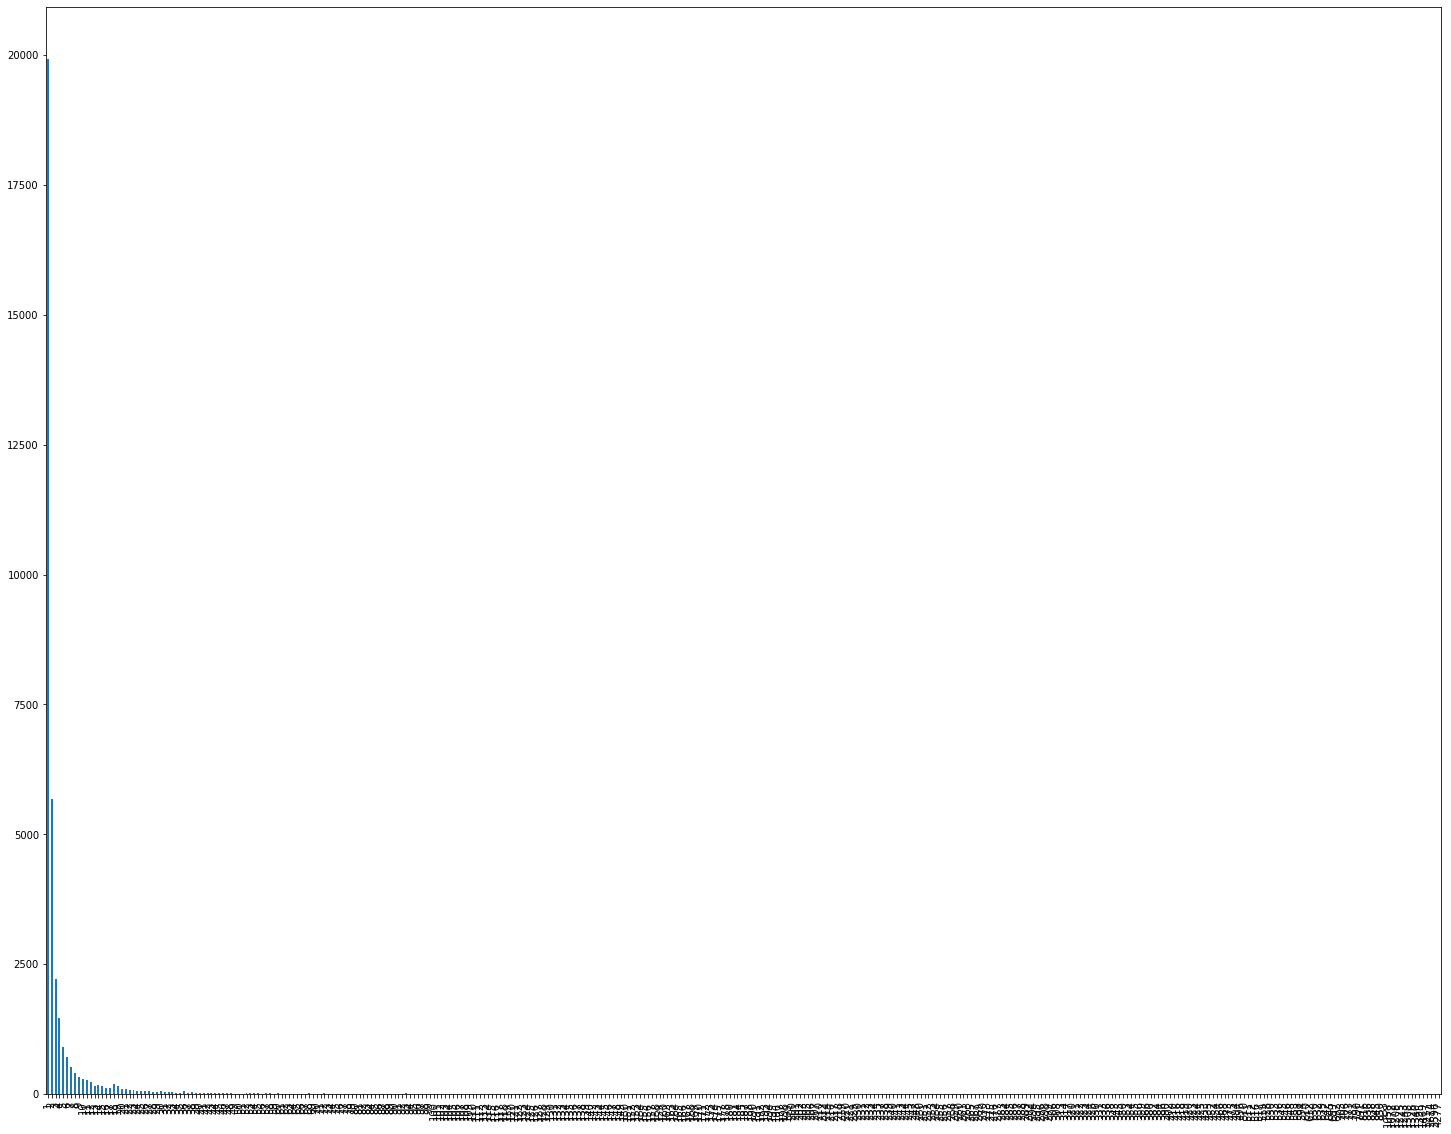

In [12]:
word_count_plot = word_count_dataframe.word_count.value_counts().sort_index(axis=0)

word_count_plot.plot(kind='bar', figsize=(25,20))

This chart shows that the vast majority of words appear a small number of times. The slider below can be used to see how many words appear less than *n* number of times

In [14]:
from ipywidgets import interact, IntSlider
import ipywidgets as widgets

def f(x):
    print(f"The percentage of words that appears more than {x} times are  { round(len(word_count_dataframe[word_count_dataframe.word_count > x]) / len(word_count_dataframe), 2) * 100 } ")



# Generate a slider 
interact(f, x=widgets.IntSlider(step=1, value=1));


interactive(children=(IntSlider(value=1, description='x'), Output()), _dom_classes=('widget-interact',))

# Clean Reddit Text

The topic analysis is 

In [16]:
topic_num = 5
alpha = 'default'
beta = 'default'

topic_a.calculate_model_score(topic_num= topic_num, alpha=alpha, beta = beta)

100%|██████████| 1/1 [00:40<00:00, 40.91s/it]


,coherence_score,topic_num,alpha,beta
0,0.544381,5,symmetric,None


In [18]:
topic_a.model_LDA()
topic_a.output_topics()

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


,topic,key_terms,example,frequency,percent
0.0,Topic #0,"com, https, https www, www, 2020",Coronavirus: Ontario premier tours school amid...,807,8.516252
1.0,Topic #1,"biden, https, amp, joe, opencorporates",MAGA Fans Back Teen Vigilante During Eerie Tru...,1795,18.942592
2.0,Topic #2,"www, com, http www, cectank, www cectank com",[100% Off] Personal Emergency Planning (Corona...,805,8.495146
3.0,Topic #3,"amp, coronavirus, https, com, www",[National] - Coronavirus Briefing: What Happen...,1460,15.407345
4.0,Topic #4,"people, like, know, time, say",Coronavirus: Apple iPhones can contact-trace w...,4574,48.269312


# Problem
The model has a high topic coherenece score, so in theory the model is good. But....
Looking at the topics and they don;t seem to be very good. Topic 4 -  www, com, http, http www, cectank	seems to be just noise. 

# Solution
The data has already been through a process where it has had stop words removed. But this uses the spacy python library stop words which are for general english but not stop words for reddit. The reddit data needs cleaning.

## Attpet 1

First thing to try is removing all word of a low frequency. Above showed that many words appear only once, this is likely to be noise so these will be removed. 


In [20]:
def remove_words_lists_of_lists(list_of_lists, to_delete):

    def filter_structure(predicate, iterable):
        for item in iterable:
            if type(item) is type(iterable):
                yield type(item)(filter_structure(predicate, item))
            else:
                if predicate(item):
                    yield item

    output_desired = list(filter_structure(lambda x: x not in to_delete, list_of_lists))

    return output_desired

def list_of_list_elements(list_of_lists):
    
    count = 0
    for ele in list_of_lists:
        count += len(ele)

    print(f"There are {count} elements in all the lists")

    return count

In [55]:
import time
start = time.time()

custom_words_to_remove = ["com", "http","www", "https"]

single_instance_words_df =  word_count_dataframe[word_count_dataframe["word_count"] == 1]

single_instance_words_list= single_instance_words_df['lemma'].tolist()

single_instance_words_list.extend(custom_words_to_remove)

output_desired = remove_words_lists_of_lists(words, single_instance_words_list)

print(f"There were {list_of_list_elements(words) -  list_of_list_elements(output_desired)} words removed")
 
end = time.time()
print(f" This took {(end - start) / 60 } minutes")


There are 320695 elements in all the lists
There are 300742 elements in all the lists
There were 19953 words removed
 This took 1.7414414485295613 minutes


In [94]:
topic_a.update_lemmas_tfidf(output_desired)


In [95]:
topic_a.model_LDA()
topic_a.output_topics()

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


,topic,key_terms,example,frequency,percent
0.0,Topic #0,"com, https, amp, www, gt",Wang Yi's Lies over Coronavirus........,851,8.980583
1.0,Topic #1,"coronavirus, kenosha, president, 19, biden",'Morning Joe' Suggests Trump Beholden to Viole...,3460,36.513297
2.0,Topic #2,"https, amp, com, opencorporates, companies",[Op-Ed] - Joy Reid flips an old attack on its ...,850,8.970030
3.0,Topic #3,"people, like, know, coronavirus, time",Bernie Sanders: It’s no great secret that Joe ...,3616,38.159561
4.0,Topic #4,"com, http, www, http www, www cectank",I (31m) changed my mind about moving out with ...,652,6.880540


In [74]:
words = topic_a.lemmas

merged = list(itertools.chain(*words))

word_count = count_words(merged)

word_count_ordered = sorted(word_count.items(), key=lambda x: x[1], reverse=True)

word_count_dataframe = pd.DataFrame(word_count_ordered)

word_count_dataframe = word_count_dataframe.rename(columns= {0: 'lemma', 1: 'word_count'})